In [3]:
%%capture
!pip install kornia

In [4]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

import torch
import torchvision
import kornia

In [5]:
def imshow(input: torch.Tensor):
    out: torch.Tensor = torchvision.utils.make_grid(input, nrow=2, padding=5)
    out_np: np.ndarray = kornia.utils.tensor_to_image(out)
    plt.imshow(out_np)
    plt.axis('off')
    plt.show()

In [6]:
!wget -q https://github.com/kornia/data/raw/main/squirrel.jpg

In [7]:
# Read the image with OpenCV
img: np.ndarray = cv2.imread('squirrel.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


In [8]:
#convert image to tensor
data: torch.tensor = kornia.utils.image_to_tensor(img, keepdim=False)
data_original = data
data = data.float() / 255.

# Brightness

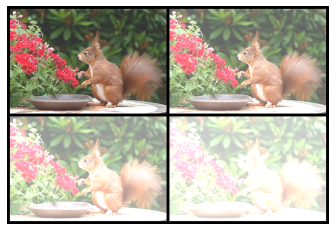

In [9]:
x_out: torch.Tensor = kornia.enhance.adjust_brightness(
    data, torch.linspace(0.2, 0.8, 4))
imshow(x_out)

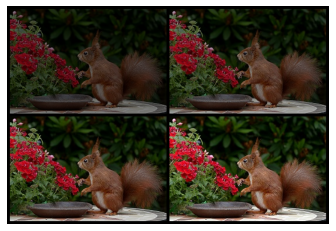

In [10]:
x_out: torch.Tensor = kornia.enhance.adjust_contrast(
    data, torch.linspace(0.5, 1., 4))
imshow(x_out)

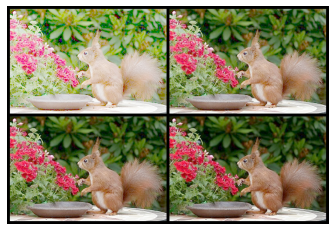

In [11]:
x_out: torch.Tensor = kornia.enhance.adjust_gamma(
    data, torch.tensor([0.2, 0.4, 0.5, 0.6]))
imshow(x_out)

# Sharpen

In [12]:
sharpen = kornia.filters.UnsharpMask((9,9), (2.5,2.5))
sharpened_tensor = sharpen(data)
difference = (sharpened_tensor - data).abs()


In [13]:
# Converting the sharpened tensor to image
sharpened_image = kornia.utils.tensor_to_image(sharpened_tensor) 
difference_image = kornia.utils.tensor_to_image(difference)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


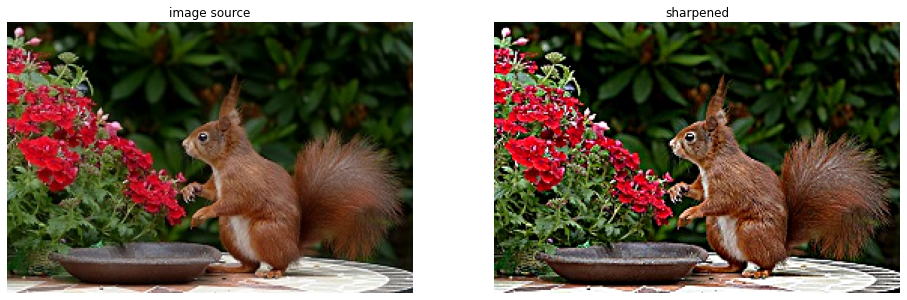

In [14]:
# To display the input image, sharpened image and the difference image
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('image source')
axs[0].imshow(img)

axs[1].axis('off')
axs[1].set_title('sharpened')
axs[1].imshow(sharpened_image)

plt.show()

# Blur

In [15]:
# create the operator
gauss = kornia.filters.GaussianBlur2d((3, 3), (3.5, 3.5))

# blur the image
x_blur: torch.tensor = gauss(data_original.float())

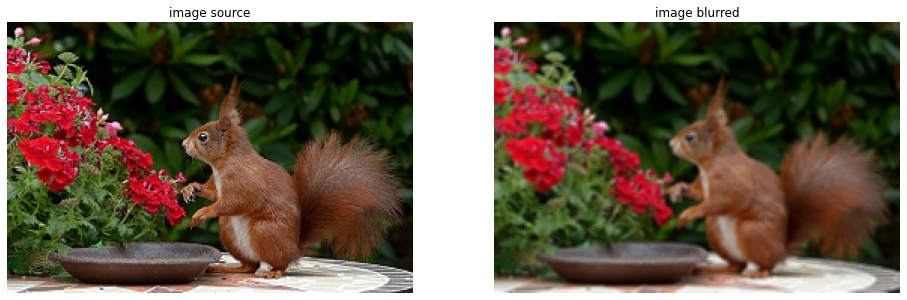

In [16]:
img_blur: np.ndarray = kornia.tensor_to_image(x_blur.byte())

# Create the plot
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('image source')
axs[0].imshow(img)

axs[1].axis('off')
axs[1].set_title('image blurred')
axs[1].imshow(img_blur)

# Filtering

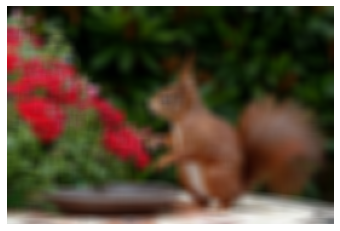

In [17]:
x_blur: torch.Tensor = kornia.filters.box_blur(data, (9, 9))
imshow(x_blur)

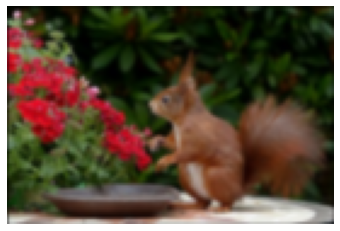

In [18]:
x_blur: torch.Tensor = kornia.filters.blur_pool2d(data, kernel_size=9)
imshow(x_blur)

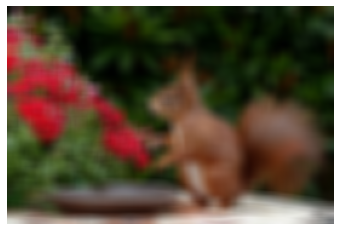

In [19]:
x_blur: torch.Tensor = kornia.filters.gaussian_blur2d(data, (11, 11), (11.0, 11.0))
imshow(x_blur)

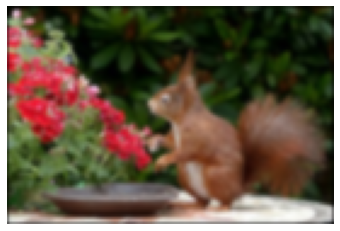

In [20]:
x_blur: torch.Tensor = kornia.filters.max_blur_pool2d(data, kernel_size=11)
imshow(x_blur)

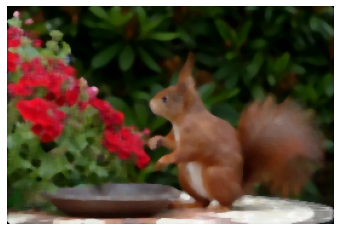

In [21]:
x_blur: torch.Tensor = kornia.filters.median_blur(data, (5, 5))
imshow(x_blur)

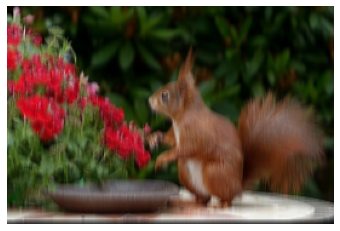

In [22]:
x_blur: torch.Tensor = kornia.filters.motion_blur(data, 9, 90., 1)
imshow(x_blur)

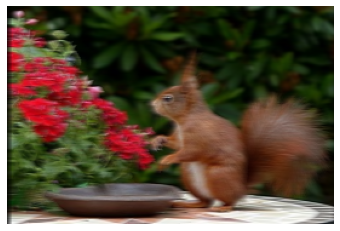

In [23]:
x_blur: torch.Tensor = kornia.filters.motion_blur(data, 9, 0., 1)
imshow(x_blur)

# Morphology

In [24]:
device = 'cpu'
kernel = torch.tensor([[0, 1, 0],[1, 1, 1],[0, 1, 0]]).to(device)

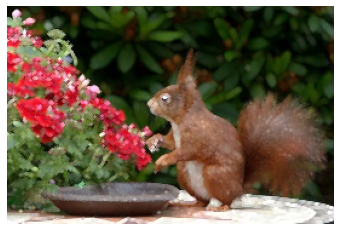

In [25]:
from kornia import morphology as morph

dilated_image = morph.dilation(data, kernel) # Dilation
imshow(dilated_image) # Plot

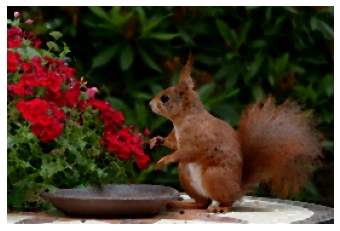

In [26]:
eroded_image = morph.erosion(data, kernel) # Erosion
imshow(eroded_image) # Plot

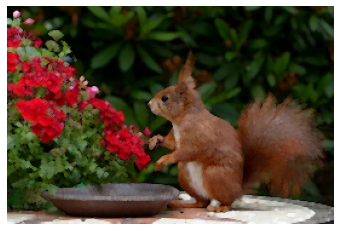

In [27]:
opened_image = morph.opening(data, kernel) # Open
imshow(opened_image)

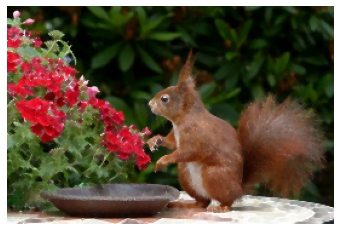

In [28]:
closed_image = morph.closing(data, kernel) # Close
imshow(closed_image) # Plot

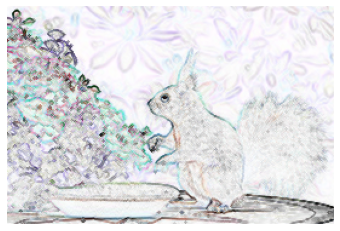

In [29]:
graded_image = morph.gradient(data, kernel) # Morphological gradient
imshow(1. - graded_image)

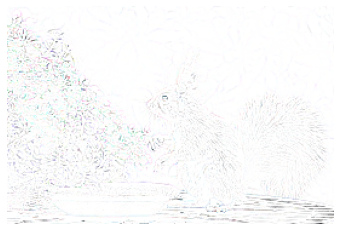

In [30]:
bottom_image = morph.bottom_hat(data, kernel) # Black Hat
imshow(1. - bottom_image)

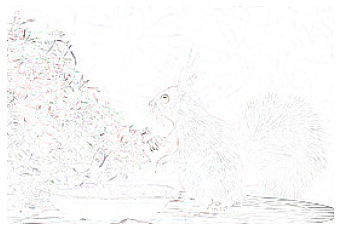

In [31]:
toph_image = morph.top_hat(data, kernel) # Top Hat
imshow(1. - toph_image)

# Patch Sequential

In [32]:
from kornia import augmentation as K
from kornia.augmentation import PatchSequential, ImageSequential
from kornia.geometry import bbox_to_mask
from kornia.utils import image_to_tensor, tensor_to_image
from torchvision.transforms import transforms

In [33]:
to_pil = transforms.ToPILImage()

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


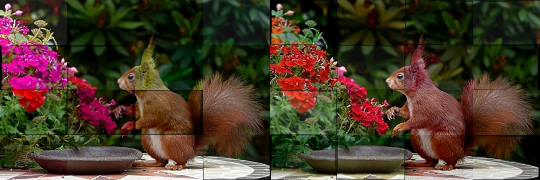

In [34]:
pseq = PatchSequential(
    K.ColorJitter(0.1, 0.1, 0.1, 0.1, p=0.75),
    K.RandomElasticTransform(alpha=(4., 4.)),
    patchwise_apply=False,
    same_on_batch=False,
)
out_tensor = pseq(data.repeat(2, 1, 1, 1))
to_pil(torch.cat([out_tensor[0], out_tensor[1]], dim=2))

# Affine Transform

In [35]:
# create transformation (rotation)
alpha: float = 45.0  # in degrees
angle: torch.tensor = torch.ones(1) * alpha

# define the rotation center
center: torch.tensor = torch.ones(1, 2)
center[..., 0] = data.shape[3] / 2  # x
center[..., 1] = data.shape[2] / 2  # y

# define the scale factor
scale: torch.tensor = torch.ones(1, 2)

# compute the transformation matrix
M: torch.tensor = kornia.geometry.get_rotation_matrix2d(center, angle, scale)  # 1x2x3

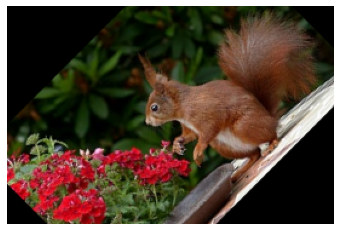

In [36]:
_, _, h, w = data.shape
x_warped: torch.tensor = kornia.geometry.warp_affine(data, M, dsize=(h, w))

imshow(x_warped)

In [37]:
def imshow2(input: torch.Tensor, size: tuple = None):
    out = torchvision.utils.make_grid(input, nrow=4, padding=5)
    out_np: np.ndarray = kornia.utils.tensor_to_image(out)
    plt.figure(figsize=size)
    plt.imshow(out_np)
    plt.axis('off')
    plt.show()

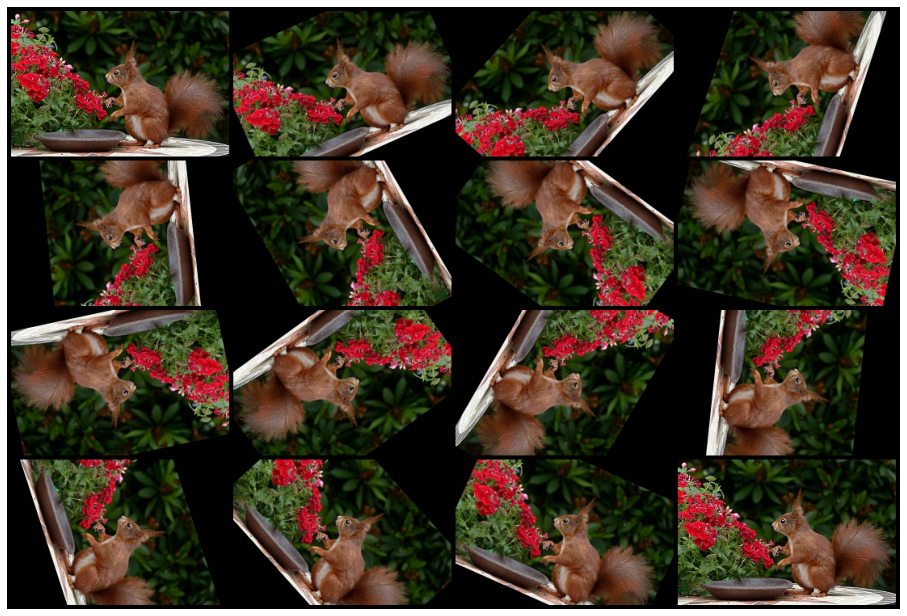

In [38]:
x_batch = data.repeat(16, 1, 1, 1)
x_rot = kornia.geometry.rotate(x_batch, torch.linspace(0., 360., 16))

imshow2(x_rot, (16, 16))

# Histogram Equalization

In [39]:
from typing import List, Tuple

In [40]:
img_lab: torch.Tensor = kornia.color.rgb_to_lab(data)
lightness: torch.Tensor = data[..., :1, :, :] / 100. # L in lab is in range [0, 100]

In [41]:
def histogram_img(img_t: torch.Tensor, size: Tuple[int, int] = (16, 4)):
    CH, H, W = img_t.shape
    img = kornia.utils.tensor_to_image(img_t.mul(255.).byte())

    plt.figure(figsize=size)
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)

    colors = ('b','g','r')
    kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, ec="k")

    for i in range(CH):
        img_vec = img[..., i].flatten()
        ax2.hist(img_vec, range=(0, 255), bins=256, color=colors[i], **kwargs)

    ax1.imshow(img, cmap=(None if CH > 1 else 'gray'))
    ax1.grid(False)
    ax1.axis('off')

    plt.show()

In [42]:
plot_indices: int = 0  # try: [0, 1, 2, 3]

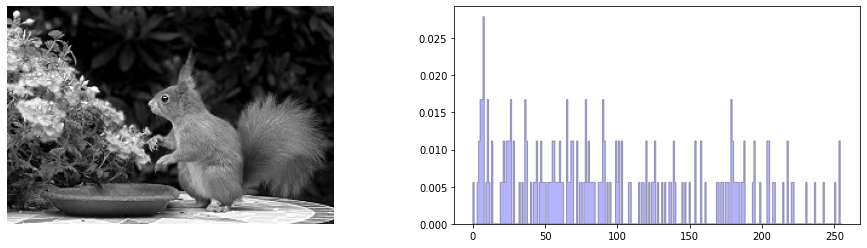

In [43]:
lightness_stretched = kornia.enhance.normalize_min_max(lightness)
histogram_img(lightness_stretched[plot_indices])

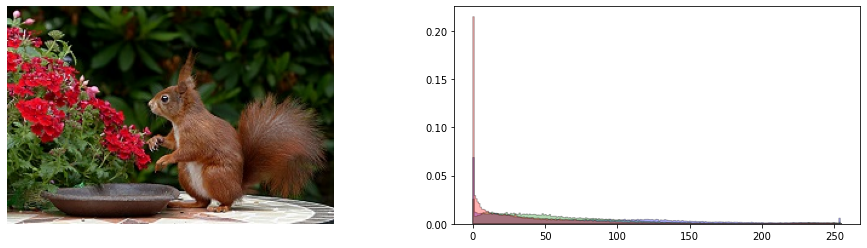

In [44]:
rgb_stretched = kornia.enhance.normalize_min_max(data)
histogram_img(rgb_stretched[plot_indices])

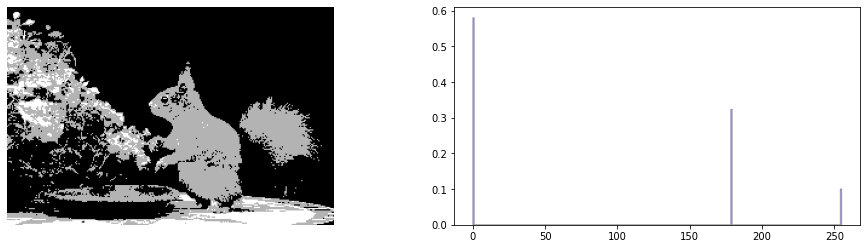

In [45]:
lightness_equalized = kornia.enhance.equalize(lightness)
histogram_img(lightness_equalized[plot_indices])

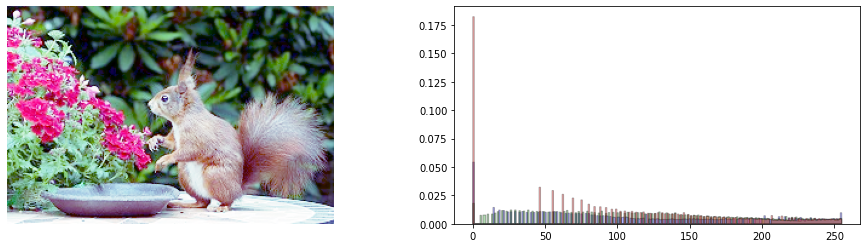

In [46]:
rgb_equalized = kornia.enhance.equalize(data)
histogram_img(rgb_equalized[plot_indices])

# Canny

In [47]:
canny = kornia.filters.Canny()

# blur the image
x_magnitude, x_canny = canny(data.float())

In [48]:
img_magnitude: np.ndarray = kornia.tensor_to_image(x_magnitude.byte())
img_canny: np.ndarray = kornia.tensor_to_image(x_canny.byte())

In [49]:
# create the operator
canny = kornia.filters.Canny(low_threshold=0.4, high_threshold=0.5)

# blur the image
_, x_canny_threshold = canny(data.float())

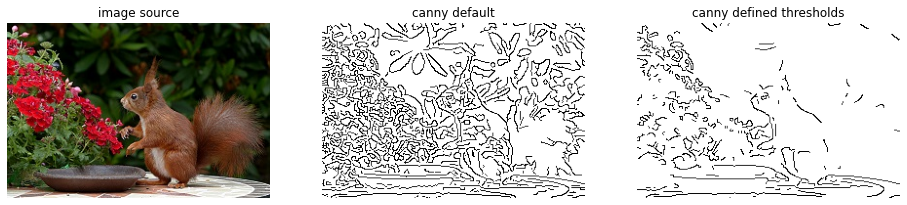

In [50]:
import torch.nn.functional as F
# convert back to numpy
img_canny_threshold: np.ndarray = kornia.tensor_to_image(x_canny_threshold.byte())

# Create the plot
fig, axs = plt.subplots(1, 3, figsize=(16,16))
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('image source')
axs[0].imshow(img)

axs[1].axis('off')
axs[1].set_title('canny default')
axs[1].imshow(img_canny, cmap='Greys')

axs[2].axis('off')
axs[2].set_title('canny defined thresholds')
axs[2].imshow(img_canny_threshold, cmap='Greys')

plt.show()

# Warp

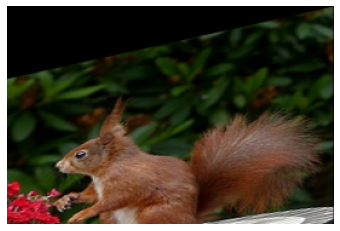

In [59]:
from kornia.geometry.transform import get_tps_transform
from kornia.geometry.transform import warp_image_tps, warp_points_tps
points_src = torch.rand(1, 3, 2)
points_dst = torch.rand(1, 3, 2)

points_src = torch.Tensor([[[1, 4], [2, 5], [1, 6]]])
points_dst = torch.Tensor([[[1, 4], [2.5, 4.5], [1, 6]]])

kernel_weights, affine_weights = get_tps_transform(points_dst, points_src)
warped_image = warp_image_tps(data, points_src, kernel_weights, affine_weights)
imshow(warped_image)